In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1475109, 25)
(709325, 22)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
use_features = pp.get_feature_list()

In [8]:
# records of last year
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, clean=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] transforming eval
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] cleaning on criteria: sold_price
[dp] cleaning on criteria: sqft_price
[dp] cleaning on criteria: sqft
[dp] cleaning on criteria: num_bed
[dp] cleaning on criteria: num_bath
[dp] cleaning on criteria: lon


(67218, 14)

In [9]:
df_track.head()

,sqft_zip_avg,num_bed,num_bath,sqft_price_zip_avg,lon,sqft,pool,sold_price_zip_avg,lat,view,impr_over_land,id,date,sold_price
1,1678.766257,1.0,1.0,264.264499,-116.96671,732,0,429138.400703,32.79673,0,1.250028,1392761,2015-10-01,158500
61301,1347.417122,1.0,1.0,391.174863,-117.20440,914,0,516158.925319,32.85025,0,0.400006,1392788,2015-10-01,318000
9718,2648.682358,3.0,2.0,324.592027,-117.11695,1410,0,858583.757422,33.01318,0,0.700000,1392721,2015-10-01,595000
9719,2648.682358,4.0,2.0,324.592027,-117.11401,2752,0,858583.757422,33.03887,0,0.948663,1392758,2015-10-01,848000
60075,1895.782219,3.0,3.0,251.726754,-116.95625,1725,0,462969.412724,32.61862,0,1.424379,1392786,2015-10-01,415000


### baseline without segment

In [10]:
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
print(df_track.shape)
monthly_volume = int(df_track.shape[0] / 24)
mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 56020, 33600, 11200
[dp] train/valid/test size: 44816, 11204, 11200
[dp] validation step is skipped


(67220, 15)


113057.2809499728

### segment on sold_price
* segment on sold_price is only for experiment, not practical in real case
* 2 segments: <1M, >=1M
* random forest

In [18]:
# < 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']<1000000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm1 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm1.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 51382, 30828, 10276
[dp] train/valid/test size: 41105, 10277, 10276
[dp] validation step is skipped


(61658, 15)


72421.23236765315

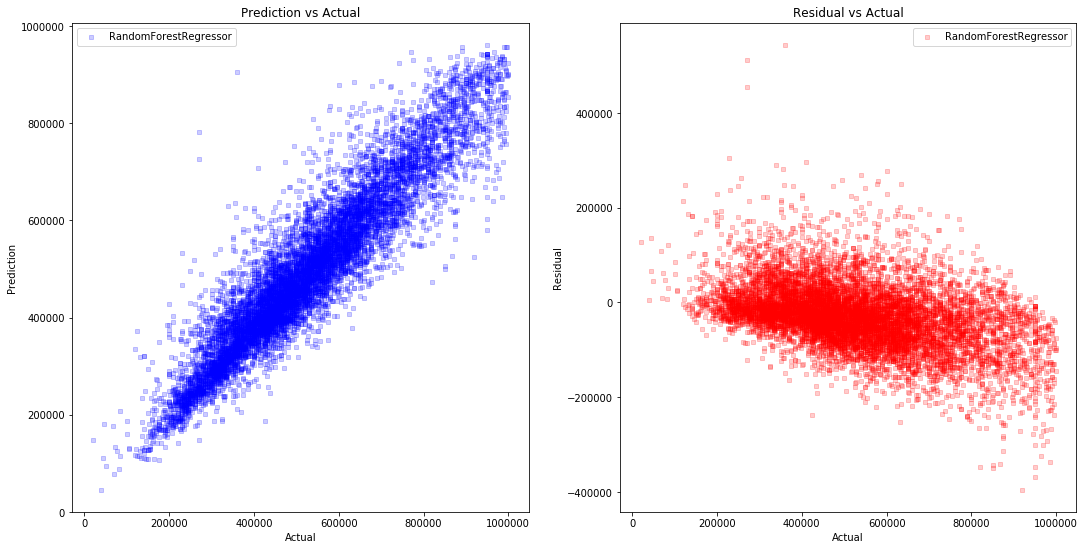

In [19]:
mm1.plot_residual()

In [14]:
# >= 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']>=1000000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm2 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm2.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 4638, 2772, 924
[dp] train/valid/test size: 3710, 928, 924
[dp] validation step is skipped


(5562, 15)


240146.93592232917

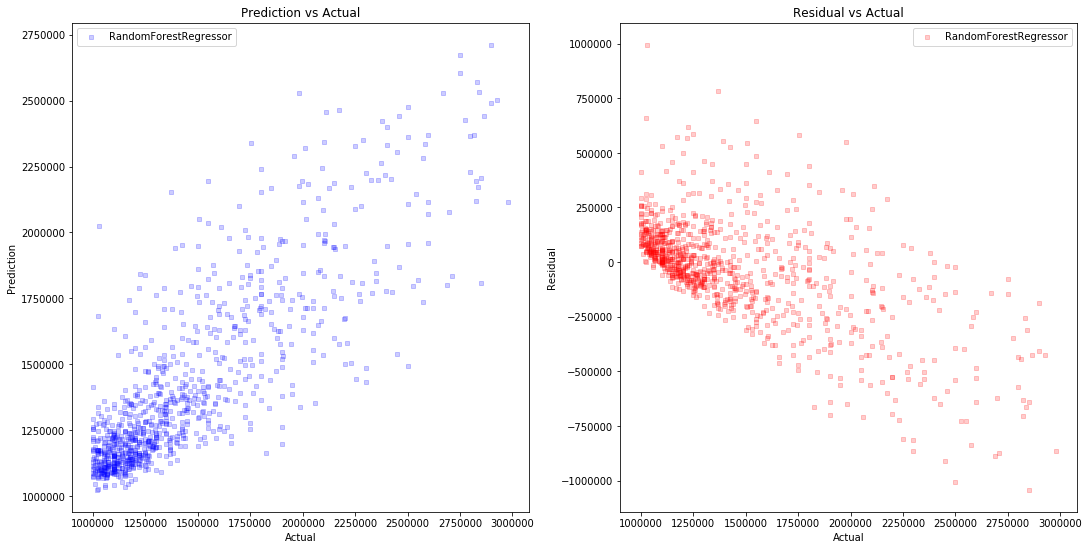

In [15]:
mm2.plot_residual()

In [16]:
def remeasure(df_checks):
    df_merged = pd.concat(df_checks)
    print(df_merged.shape)
    return sqrt(mean_squared_error(df_merged['predict'], df_merged['sold_price']))

df_check1 = mm1.get_result_df()
df_check2 = mm2.get_result_df()
remeasure([df_check1, df_check2])

(11200, 17)


97826.15428558146

In [17]:
### 3 segments
# < 0.6M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']<600000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm1 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm1.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

# .6M ~ 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[(df_track['sold_price']>=600000)&(df_track['sold_price']<1000000)]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm2 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm2.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

# >= 1M
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']>=1000000]
print(df_track_filter.shape)
monthly_volume = int(df_track_filter.shape[0] / 24)
mm3 = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm3.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

df_check1 = mm1.get_result_df()
df_check2 = mm2.get_result_df()
df_check3 = mm3.get_result_df()
remeasure([df_check1, df_check2, df_check3])

[dp] track/sliding/test window size: 37769, 22656, 7552
[dp] train/valid/test size: 30215, 7554, 7552
[dp] validation step is skipped


(45321, 15)


[dp] track/sliding/test window size: 13617, 8160, 2720
[dp] train/valid/test size: 10893, 2724, 2720
[dp] validation step is skipped


(16337, 15)


[dp] track/sliding/test window size: 4638, 2772, 924
[dp] train/valid/test size: 3710, 928, 924
[dp] validation step is skipped


(5562, 15)
(11196, 17)


89220.40904491283